**Описание проекта**

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

В процессе исследования предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов с целью установить наиболее прибыльный. В процессе работы предстоит подтвердить или опровергнуть следующие гепотезы: 
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Чтобы в дальнейшем не перегружать объяснения, привожу здесь информацию о тарифах.

**Тариф «Смарт»**
- Ежемесячная плата: 550 рублей
- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:минута разговора: 3 рубля   сообщение: 3 рубля  1 Гб интернет-трафика: 200 рублей

**Тариф «Ультра»**
- Ежемесячная плата: 1950 рублей
- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:  минута разговора: 1 рубль  сообщение: 1 рубль  1 Гб интернет-трафика: 150 рублей
**Примечание:**

«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.

Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

**1. Взглянем на файлы:**

In [1]:
import pandas as pd
import seaborn as sns
sns.set(palette='tab20b',  color_codes=False)

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from pandas.core import apply
from functools import reduce
idx = pd.IndexSlice
from scipy import stats as st
import math

calls = pd.read_csv(r'/datasets/calls.csv', index_col=0)
internet = pd.read_csv(r'/datasets/internet.csv', index_col=0)
messages = pd.read_csv(r'/datasets/messages.csv', index_col=0)
tariffs = pd.read_csv(r'/datasets/tariffs.csv', index_col=0)
users = pd.read_csv(r'/datasets/users.csv', index_col=0)

print('Выводим информацию о файлах:')
print()
for data in [calls, internet, messages, users, tariffs]: print(data.info(), end='\n\n')
print()


Выводим информацию о файлах:

<class 'pandas.core.frame.DataFrame'>
Index: 202607 entries, 1000_0 to 1499_219
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   call_date  202607 non-null  object 
 1   duration   202607 non-null  float64
 2   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 6.2+ MB
None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB
None

<class 'pandas.core.frame.DataFrame'>
Index: 123036 entries, 1000_0 to 1499_183
Data columns (total 2 columns):
 #   Column        Non-Null Cou

In [2]:
print('Выведем первые строки таблиц:')
print()
for data in [calls, internet, messages, users, tariffs]: print(data.head(), end='\n\n')
print('В некоторых датафреймах необходимо ввести индексы')

Выведем первые строки таблиц:

         call_date  duration  user_id
id                                   
1000_0  2018-07-25      0.00     1000
1000_1  2018-08-17      0.00     1000
1000_2  2018-06-11      2.85     1000
1000_3  2018-09-21     13.80     1000
1000_4  2018-12-15      5.18     1000

       id  mb_used session_date  user_id
0  1000_0   112.95   2018-11-25     1000
1  1000_1  1052.81   2018-09-07     1000
2  1000_2  1197.26   2018-06-25     1000
3  1000_3   550.27   2018-08-22     1000
4  1000_4   302.56   2018-09-24     1000

       message_date  user_id
id                          
1000_0   2018-06-27     1000
1000_1   2018-10-08     1000
1000_2   2018-08-04     1000
1000_3   2018-06-16     1000
1000_4   2018-12-05     1000

         age churn_date         city first_name  last_name    reg_date tariff
user_id                                                                      
1000      52        NaN    Краснодар     Рафаил  Верещагин  2018-05-25  ultra
1001      41     

In [3]:
print('В некоторых датафреймах необходимо ввести индексы строк и перевести столбцы, которые сейчас недоступны для из-за "индексации", в общий ранг.')
print('Используем .reset_index')
tariffs = tariffs.reset_index(level=0)
calls = calls.reset_index(level=0)
messages = messages.reset_index(level=0)
users = users.reset_index(level=0)

В некоторых датафреймах необходимо ввести индексы строк и перевести столбцы, которые сейчас недоступны для из-за "индексации", в общий ранг.
Используем .reset_index


**Вывод:** 
В предоставленных файлах содержится информация о 500 клиентах. Личные данные, данные о тарифах, количестве звонков, сообщений, трафика разбиты на несколько таблиц, объединенных id клиентов. Я добавила недостающие столбцы с индексами. Далее необходимо привести информацию в таблицах в пригодный для исследования вид. 

**2. Подготовим данные для дальнейшей работы.**

In [4]:
print('Скорректируем типы данных в столбцах "session_date", "message_date" , "churn_day", "reg_date" предоставленных таблиц.')
print('Переведем столбцы с датами со строчного типа в временной и выведем для проверки:')
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')


print('"call_date" -', calls['call_date'].dtypes)
print('"session_date" - '  , internet['session_date'].dtypes)
print('"message_date" - ',  messages['message_date'].dtypes)
print('"churn_day" - ' , users['churn_date'].dtypes)
print('"reg_date" - ', users['reg_date'].dtypes)

Скорректируем типы данных в столбцах "session_date", "message_date" , "churn_day", "reg_date" предоставленных таблиц.
Переведем столбцы с датами со строчного типа в временной и выведем для проверки:
"call_date" - datetime64[ns]
"session_date" -  datetime64[ns]
"message_date" -  datetime64[ns]
"churn_day" -  datetime64[ns]
"reg_date" -  datetime64[ns]


In [5]:
print('Округляем данные в столбцах с длительностью звонков и мегабайтов траффика до целых чисел в большую сторону, т к тариф предусматривает оплату по целым минутам и гигабайтам. ')
print('В дальнейшем нам понадобятся данные и о мегабайтах, и о гигабайтах. Но в гигабайты логичней перевести в процессе.')
calls['duration']=calls['duration'].apply(np.ceil)



Округляем данные в столбцах с длительностью звонков и мегабайтов траффика до целых чисел в большую сторону, т к тариф предусматривает оплату по целым минутам и гигабайтам. 
В дальнейшем нам понадобятся данные и о мегабайтах, и о гигабайтах. Но в гигабайты логичней перевести в процессе.


In [6]:
print('Проверяем, есть ли пропуски:')
print()
print(calls.isna().sum())
print()
print(internet.isna().sum()) 
print()
print(messages.isna().sum())
print()
print(tariffs.isna().sum())
print()
print(users.isna().sum()) 
print()
print('Проверяем, есть ли полные дубликаты:')
print()
print('calls -', calls.duplicated().sum())
print('internet - ', internet.duplicated().sum()) 
print('messages - ', messages.duplicated().sum()) 
print('tariffs -', tariffs.duplicated().sum())
print('users -', users.duplicated().sum()) 

Проверяем, есть ли пропуски:

id           0
call_date    0
duration     0
user_id      0
dtype: int64

id              0
mb_used         0
session_date    0
user_id         0
dtype: int64

id              0
message_date    0
user_id         0
dtype: int64

messages_included        0
mb_per_month_included    0
minutes_included         0
rub_monthly_fee          0
rub_per_gb               0
rub_per_message          0
rub_per_minute           0
tariff_name              0
dtype: int64

user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

Проверяем, есть ли полные дубликаты:

calls - 0
internet -  0
messages -  0
tariffs - 0
users - 0


**Вывод:**
Дубликаты отсутствуют.
Видим, что пропуски присутствуют в таблице с личными данными пользователей в столбце с датой прекращения пользования тарифом. Исходя из имеющейся информации, пропуск свидетельствует, что пользователь не менял тариф с момента регистрации. 
Решено пока не трогать эти пропуски. 

**3. Проанализируем данные по необходимым в дальнейшем столбца по отдельности.**

В частности, по звонкам и интернет-траффику. С прочими столбцами сложно применить подобный метод, да и нет смысла.

**Звонки.**

In [7]:

print('Методом describe получаем статистическую информацию о значениях  в столбце:')
print(calls['duration'].describe())
print('Видно, что имеются нулевые значения, что, вероятно, связано с  крайне низкой длительностью звонка, однако в системе он зарегистрирован и логично предположить, что согласно условию тарифа списание за него произошло.')
print('Аномальных значений не выявлено, всё в пределах разумного.  ')
print('Считаем количество "нулевых" звонков:  ',
(
calls.loc[calls['duration'] == 0, 'duration'].value_counts()[0]))


Методом describe получаем статистическую информацию о значениях  в столбце:
count    202607.000000
mean          7.158198
std           5.959173
min           0.000000
25%           2.000000
50%           6.000000
75%          11.000000
max          38.000000
Name: duration, dtype: float64
Видно, что имеются нулевые значения, что, вероятно, связано с  крайне низкой длительностью звонка, однако в системе он зарегистрирован и логично предположить, что согласно условию тарифа списание за него произошло.
Аномальных значений не выявлено, всё в пределах разумного.  
Считаем количество "нулевых" звонков:   39613


**Интернет-сессии**

Методом describe получаем статистическую информацию о значениях  в столбце:
count    149396.000000
mean        370.192426
std         278.300951
min           0.000000
25%         138.187500
50%         348.015000
75%         559.552500
max        1724.830000
Name: mb_used, dtype: float64
Как мы видим, здесь так же присутствуют зарегистрированные нулевые значения.
По аналогии с предыдущим пунктом, добавим столбец со значением месяца и построим график зависимости.
  


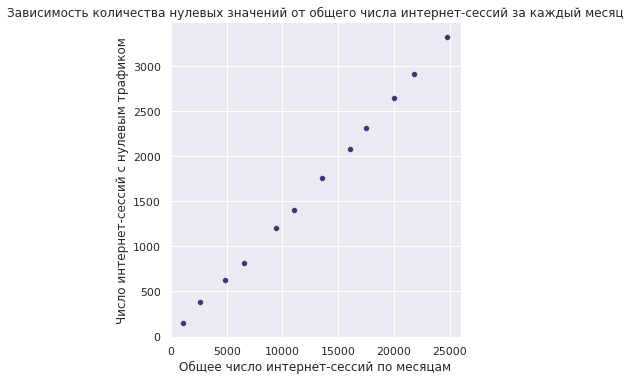

In [8]:
print('Методом describe получаем статистическую информацию о значениях  в столбце:')
print(internet['mb_used'].describe())
print('Как мы видим, здесь так же присутствуют зарегистрированные нулевые значения.')
print('По аналогии с предыдущим пунктом, добавим столбец со значением месяца и построим график зависимости.')
print('  ')
internet['month'] = internet['session_date'].dt.month

internet.loc[internet['mb_used'] == 0, 'nulls_count'] = 1
null_mb = internet.pivot_table(index='month', values=['id', 'nulls_count'], aggfunc='count')
null_mb['null_ratio'] = round(null_mb['nulls_count'] / null_mb['id'], 3)

sns.relplot(x='id', y='nulls_count', data=null_mb)
plt.xlabel('Общее число интернет-сессий по месяцам')
plt.ylabel('Число интернет-сессий с нулевым трафиком')
_ = plt.title('Зависимость количества нулевых значений от общего числа интернет-сессий за каждый месяц')



In [9]:
print('Вывод по нулевым значениям интернет-сесссий аналогичен. Т к тариф считается по мегабайтам, так же заменяем нулевые значения на единицу.')


Вывод по нулевым значениям интернет-сесссий аналогичен. Т к тариф считается по мегабайтам, так же заменяем нулевые значения на единицу.


**4. Формируем сводную таблицу.**

Найдем для каждого пользователя:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам.

In [10]:
calls['month'] = calls['call_date'].dt.month
users['unique_name'] = users['city'] + users['first_name'] + users['last_name']


print('  ')
print('Формируем сводную таблицу по звонкам.')


calls_temp = calls.merge(users, on='user_id', how='inner')
calls_grouped = calls_temp.pivot_table(values=['unique_name', 'duration'], 
                       index=['user_id', 'month'], 
                       aggfunc={'unique_name': 'count', 'duration': 'sum'})
calls_grouped.columns = ['duration', 'calls']

print('Проверяем:')
print(calls_grouped.head())

print('  ')
print('По тому же принципу формируем таблицы по сообщениям и интернет-трафику.')

messages['month'] = messages['message_date'].dt.month
messages_temp = messages.merge(users, on='user_id', how='inner')
messages_grouped = messages_temp.pivot_table(values='unique_name', 
                       index=['user_id', 'month'], 
                       aggfunc={'unique_name': 'count'})
messages_grouped.columns = ['messages']


internet['month'] = internet['session_date'].dt.month
internet_temp = internet.merge(users, on='user_id', how='inner')
internet_grouped = internet_temp.pivot_table(values='mb_used', 
                       index=['user_id', 'month'], 
                       aggfunc={'mb_used': 'sum'})
internet_grouped.columns = ['mb_used']





print('  ')
print('Далее объединяем полученые таблицы в одну:')
dfs = [calls_grouped, messages_grouped, internet_grouped]
grouped_data = reduce(lambda left,right: pd.merge(left,right,on=['user_id', 'month'], how='outer'), dfs)


grouped_data.head(10)

  
Формируем сводную таблицу по звонкам.
Проверяем:
               duration  calls
user_id month                 
1000    5         159.0     22
        6         172.0     43
        7         340.0     47
        8         408.0     52
        9         466.0     58
  
По тому же принципу формируем таблицы по сообщениям и интернет-трафику.
  
Далее объединяем полученые таблицы в одну:


duration  calls  messages   mb_used
user_id month                                     
1000    5         159.0   22.0      22.0   2253.49
        6         172.0   43.0      60.0  23233.77
        7         340.0   47.0      75.0  14003.64
        8         408.0   52.0      81.0  14055.93
        9         466.0   58.0      57.0  14568.91
        10        350.0   57.0      73.0  14702.49
        11        338.0   43.0      58.0  14756.47
        12        333.0   46.0      70.0   9817.61
1001    11        430.0   59.0       NaN  18429.34
        12        414.0   63.0       NaN  14036.66

In [11]:
#При формировании таблицы два первых столбца оказались переведены в индекс-столбцы, исправляю:
grouped_data=grouped_data.reset_index(level=0)
grouped_data=grouped_data.reset_index(level=0)
grouped_data.head()

,month,user_id,duration,calls,messages,mb_used
0,5,1000,159.0,22.0,22.0,2253.49
1,6,1000,172.0,43.0,60.0,23233.77
2,7,1000,340.0,47.0,75.0,14003.64
3,8,1000,408.0,52.0,81.0,14055.93
4,9,1000,466.0,58.0,57.0,14568.91


**Сводная таблица с данными по пользователям.**

Сформируем сводные таблицы, состоящие из индивидуального идентификатора пользователя(город+имя+фамилия), количества его звонков и израсходованных минут по месяцам, количества отправленных им сообщений и количества затраченных мегабайт интернет-трафика.

In [12]:
print('Выводим статистическую информацию о получившейся таблице describe')
print(grouped_data.describe()) 
print('  ')
print('Выводим информацию о пропусках:')
print(grouped_data.isna().sum())
print('  ')
print('Можно предположить, что пропуски - результат того, что в определенном месяце пользователь функцией не пользовался')
print('Заполняем пропущенные графы 0.')

grouped_data.loc[grouped_data['duration'].isna(), 'duration'] = 0
grouped_data.loc[grouped_data['messages'].isna(), 'messages'] = 0
grouped_data.loc[grouped_data['mb_used'].isna(), 'mb_used'] = 0
grouped_data.loc[grouped_data['calls'].isna(), 'calls'] = 0

print('Проверяем:')
print(grouped_data.isna().sum())

grouped_data.head()

Выводим статистическую информацию о получившейся таблице describe
             month      user_id     duration        calls     messages  \
count  3214.000000  3214.000000  3174.000000  3174.000000  2717.000000   
mean      8.317362  1251.590230   456.931632    63.833333    45.283769   
std       2.905413   144.659172   238.031270    32.678036    35.051363   
min       1.000000  1000.000000     0.000000     1.000000     1.000000   
25%       6.000000  1125.000000   290.000000    41.000000    19.000000   
50%       9.000000  1253.000000   447.000000    63.000000    38.000000   
75%      11.000000  1378.750000   592.000000    83.000000    63.000000   
max      12.000000  1499.000000  1673.000000   244.000000   224.000000   

            mb_used  
count   3203.000000  
mean   17266.708626  
std     7516.356902  
min        0.000000  
25%    12526.905000  
50%    16963.110000  
75%    21432.175000  
max    49745.690000  
  
Выводим информацию о пропусках:
month         0
user_id       0
du

,month,user_id,duration,calls,messages,mb_used
0,5,1000,159.0,22.0,22.0,2253.49
1,6,1000,172.0,43.0,60.0,23233.77
2,7,1000,340.0,47.0,75.0,14003.64
3,8,1000,408.0,52.0,81.0,14055.93
4,9,1000,466.0,58.0,57.0,14568.91


**Определяем выручку от каждого пользователя**

Для этого сначала отнимаем бесплатный пакет из суммарного количества звонков, сообщений и трафика. Затем остаток умножаем на значение тарифоного плана и прибавим абонентскую плату соответственно тарифу.


In [13]:
print('Сначала добавим в сводную таблицу наименование тарифного плана каждого пользователя методом merge.')
print('Для проверки присоединения буду сверять количество строк:', len(grouped_data))


tariffs = tariffs.reset_index(level=0)
users = users.reset_index(level=0)

users.set_index('user_id', inplace=True)

grouped_data = grouped_data.merge(users['tariff'], on='user_id')

grouped_data = grouped_data.merge(users['city'], on='user_id')



print('Количество строк по итогу совпадает:', len(grouped_data))
grouped_data.head()

Сначала добавим в сводную таблицу наименование тарифного плана каждого пользователя методом merge.
Для проверки присоединения буду сверять количество строк: 3214
Количество строк по итогу совпадает: 3214


,month,user_id,duration,calls,messages,mb_used,tariff,city
0,5,1000,159.0,22.0,22.0,2253.49,ultra,Краснодар
1,6,1000,172.0,43.0,60.0,23233.77,ultra,Краснодар
2,7,1000,340.0,47.0,75.0,14003.64,ultra,Краснодар
3,8,1000,408.0,52.0,81.0,14055.93,ultra,Краснодар
4,9,1000,466.0,58.0,57.0,14568.91,ultra,Краснодар


In [14]:
tariffs['gb_per_month_included']= (tariffs['mb_per_month_included'] / 1024)
grouped_data['gb_used'] = np.ceil(grouped_data['mb_used'] / 1024)


In [15]:

print('Далее формируем функцию для подсчета выручки от каждого пользователя в месяц. Сохраняем в столбец revenue')

minutes_included_smart=tariffs.iloc[0]['minutes_included']
gb_per_month_included_smart=tariffs.iloc[0]['gb_per_month_included']
messages_included_smart=tariffs.iloc[0]['messages_included']    
    
rub_per_message_smart = tariffs.iloc[0]['rub_per_message']
rub_per_gb_smart=tariffs.iloc[0]['rub_per_gb']
rub_per_minute_smart = tariffs.iloc[0]['rub_per_minute']
rub_monthly_fee_smart= tariffs.iloc[0]['rub_monthly_fee']

minutes_included_ultra=tariffs.iloc[1]['minutes_included']
gb_per_month_included_ultra=tariffs.iloc[1]['gb_per_month_included']
messages_included_ultra=tariffs.iloc[1]['messages_included']    
    
rub_per_message_ultra= tariffs.iloc[1]['rub_per_message']
rub_per_gb_ultra =tariffs.iloc[1]['rub_per_gb']
rub_per_minute_ultra  = tariffs.iloc[1]['rub_per_minute']
rub_monthly_fee_ultra = tariffs.iloc[1]['rub_monthly_fee']




def det_revenue(row):
    messages = row['messages']
    gb_used = row['gb_used']
    duration = row['duration']
    calls = row['calls']
    tariff = row['tariff']
    
    if tariff == 'smart':
        extra_duration = duration - minutes_included_smart
        extra_gb = gb_used - gb_per_month_included_smart
        extra_messages = messages - messages_included_smart
        
        if extra_duration < 0: extra_duration = 0
        if extra_gb < 0: extra_gb = 0
        if extra_messages < 0: extra_messages = 0
        
        return (rub_per_message_smart * extra_messages + 
                rub_per_gb_smart * extra_gb + 
                rub_per_minute_smart * extra_duration + 
                rub_monthly_fee_smart) 
    else:
        extra_duration = duration -  minutes_included_ultra
        extra_gb = gb_used - gb_per_month_included_ultra
        extra_messages = messages - messages_included_ultra
        
        if extra_duration < 0: extra_duration = 0
        if extra_gb < 0: extra_gb = 0
        if extra_messages < 0: extra_messages = 0
        
        return (rub_per_message_ultra * extra_messages + 
                rub_per_gb_ultra * extra_gb + 
                rub_per_minute_ultra * extra_duration + 
                rub_monthly_fee_ultra  )

grouped_data['revenue'] = grouped_data.apply( det_revenue, axis=1)


grouped_data.head(20) #вывела больше строк, чтобы была видна правильность добавления тарифов и городов относительно пользователя и айди

Далее формируем функцию для подсчета выручки от каждого пользователя в месяц. Сохраняем в столбец revenue


,month,user_id,duration,calls,messages,mb_used,tariff,city,gb_used,revenue
0,5,1000,159.0,22.0,22.0,2253.49,ultra,Краснодар,3.0,1950.0
1,6,1000,172.0,43.0,60.0,23233.77,ultra,Краснодар,23.0,1950.0
2,7,1000,340.0,47.0,75.0,14003.64,ultra,Краснодар,14.0,1950.0
3,8,1000,408.0,52.0,81.0,14055.93,ultra,Краснодар,14.0,1950.0
4,9,1000,466.0,58.0,57.0,14568.91,ultra,Краснодар,15.0,1950.0
5,10,1000,350.0,57.0,73.0,14702.49,ultra,Краснодар,15.0,1950.0
6,11,1000,338.0,43.0,58.0,14756.47,ultra,Краснодар,15.0,1950.0
7,12,1000,333.0,46.0,70.0,9817.61,ultra,Краснодар,10.0,1950.0
8,11,1001,430.0,59.0,0.0,18429.34,smart,Москва,18.0,1150.0
9,12,1001,414.0,63.0,0.0,14036.66,smart,Москва,14.0,550.0


**5. Проверяем гипотизы**


Изучим с помощью методов описательной статистики, как клиенты используют возможности тарифов.

In [16]:
users=users.reset_index(level=0)

In [17]:
print('Посчитаем, сколько в среднем каждому пользователю требуется минут, сообщений и мегабайт в месяц и сохраняем в переменную medians. ')

medians = grouped_data.pivot_table(index='user_id', values=['duration', 'messages', 'mb_used', 'revenue'], aggfunc='median')
for index in users['user_id']:
    medians.loc[index, 'tariff'] = users.loc[index-1000, 'tariff']
    
medians.head()

Посчитаем, сколько в среднем каждому пользователю требуется минут, сообщений и мегабайт в месяц и сохраняем в переменную medians. 


,duration,mb_used,messages,revenue,tariff
user_id,,,,,
1000,339.0,14312.42,65.0,1950.0,ultra
1001,422.0,16233.00,0.0,850.0,smart
1002,214.0,17580.10,11.0,1150.0,smart
1003,824.0,11356.89,83.0,1950.0,ultra
1004,132.5,17810.53,154.5,1950.0,ultra


Методом describe получаем статистическую информацию о значениях  в столбце:
count    149396.000000
mean        370.192426
std         278.300951
min           0.000000
25%         138.187500
50%         348.015000
75%         559.552500
max        1724.830000
Name: mb_used, dtype: float64
Как мы видим, здесь так же присутствуют зарегистрированные нулевые значения.
По аналогии с предыдущим пунктом, добавим столбец со значением месяца и построим график зависимости.
  


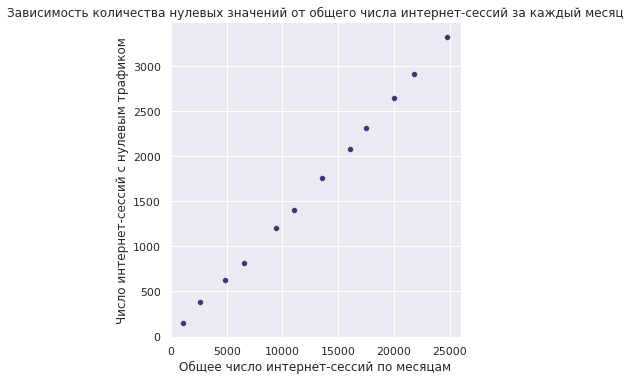

In [18]:
print('Методом describe получаем статистическую информацию о значениях  в столбце:')
print(internet['mb_used'].describe())
print('Как мы видим, здесь так же присутствуют зарегистрированные нулевые значения.')
print('По аналогии с предыдущим пунктом, добавим столбец со значением месяца и построим график зависимости.')
print('  ')
internet['month'] = internet['session_date'].dt.month

internet.loc[internet['mb_used'] == 0, 'nulls_count'] = 1
null_mb = internet.pivot_table(index='month', values=['id', 'nulls_count'], aggfunc='count')
null_mb['null_ratio'] = round(null_mb['nulls_count'] / null_mb['id'], 3)

sns.relplot(x='id', y='nulls_count', data=null_mb)
plt.xlabel('Общее число интернет-сессий по месяцам')
plt.ylabel('Число интернет-сессий с нулевым трафиком')
_ = plt.title('Зависимость количества нулевых значений от общего числа интернет-сессий за каждый месяц')



In [19]:
print('Найдем медиану, дисперсию и стандартное отклонение:')

medians.dropna(subset=['duration'], inplace=True)
desc_stat = medians.pivot_table(index=['tariff'], values=['duration', 'mb_used', 'messages'], 
                    aggfunc={'duration': [np.median, np.var, np.std], 
                             'mb_used': [np.median, np.var, np.std], 
                             'messages': [np.median, np.var, np.std]})
desc_stat.reset_index(level=0)
desc_stat

Найдем медиану, дисперсию и стандартное отклонение:


duration                               mb_used               \
         median         std           var      median          std   
tariff                                                               
smart    439.75  160.266622  25685.390127  16925.2900  4174.203404   
ultra    535.25  303.793641  92290.576519  19733.1475  8893.002882   

                     messages                          
                 var   median        std          var  
tariff                                                 
smart   1.742397e+07     28.5  28.010653   784.596662  
ultra   7.908550e+07     47.5  49.236809  2424.263318

Визуализируем для оценки разброса значений и распределение полученных данных: 

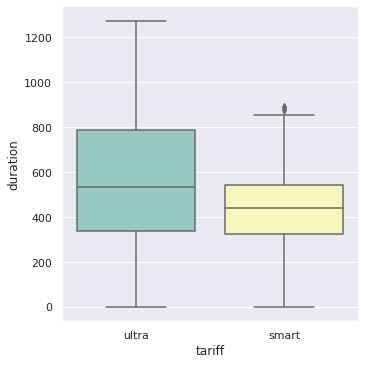

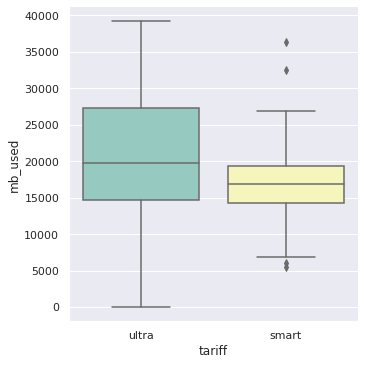

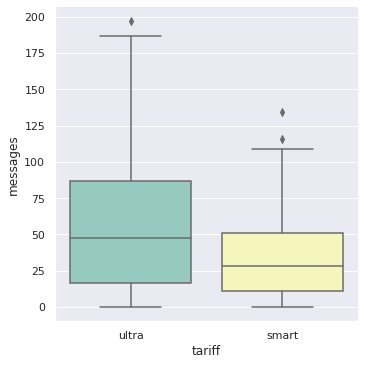

In [20]:
for column in ['duration', 'mb_used', 'messages']:    
    sns.catplot(x="tariff", y=column, kind="box", data=medians, orient='v', palette="Set3")

Минуты разговора, число сообщений и объем потраченного интернет-трафика по тарифу «Ультра» имеет большую дисперсию по сравнению с тарифом «Смарт», и медианы по вышеперечисленным признакам также смещены в большую сторону. Кроме того, выбросов в рамках более дешевого тарифа существенно больше.


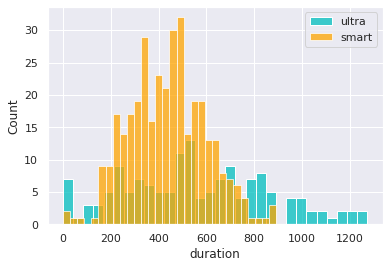

In [21]:
# Код ревь.ера

for tariff,color in zip(['ultra', 'smart'],['c','orange']):  #как бы при таком выборе гаммы яндекс.фсб проектом не заинтересовалось
    sns.histplot(medians.query('tariff == @tariff')['duration'], kde=False, label=tariff, bins=30, color=color)
_ = plt.legend(['ultra', 'smart'])

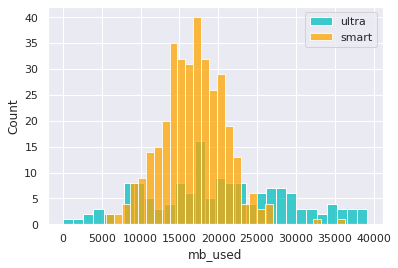

In [23]:
for tariff, color in zip(['ultra', 'smart'],['c','orange']):
    sns.histplot(medians.query('tariff == @tariff')['mb_used'], kde=False,  bins=30, color=color)
_ = plt.legend(['ultra', 'smart'])

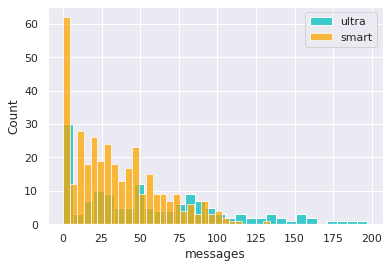

In [24]:
for tariff, color in zip(['ultra', 'smart'], ['c','orange']):
    sns.histplot(medians.query('tariff == @tariff')['messages'], kde=False, label=tariff, bins=30, color=color)
_ = plt.legend(['ultra', 'smart'])

По полученным гистограммам  можно сделать вывод, что дисперсия по тарифу "Смарт" меньше, чем у пользователей с тарифом "Ультра" по всем показателям: по длительности разговора, числу сообщений и использованному интернет-трафику. Также, видно, что мода у "Смарта" явно выражена.

Можно сделать вывод, что пользователи более дорогого тарифа используют его разнообразней, чем пользователи более дешевого. Вероятно, это связано с тем, что объем тарифа "Ультра" позволяет пользователям полностью удовлетворять свои потребности и не беспокоиться о выходе за пределы тарифа. 


**6. Проверка гипотез**

*Первая гипотеза:*

Примем за нулевую гипотезу то, что средняя выручка пользователей тарифа «Ультра» равна средней выручке пользователей тарифа «Смарт».

А в качестве альтернативной гипотезы то, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

Уровень статистической значимости примем за α=1%. Если p-значение меньше порогового значения alpha, то гипотезу отвергаем. Иначе - не отвергаем.

In [25]:
ultra = grouped_data.query('tariff == "ultra"')['revenue']
smart = grouped_data.query('tariff == "smart"')['revenue']

alpha = 0.01

results = st.ttest_ind(
    ultra, 
    smart, 
    equal_var=False)

print('Получаем:')
print('p-значение:', results.pvalue)

print('Формируем функцию, сравнивающую статитстическую значимость и полученное р-значение. Выводим результат на экран: ')
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Получаем:
p-значение: 4.2606313931076085e-250
Формируем функцию, сравнивающую статитстическую значимость и полученное р-значение. Выводим результат на экран: 
Отвергаем нулевую гипотезу


In [26]:
print('Выводим медианные значения выручки по тарифам: ')
median_reven=grouped_data.pivot_table(index='tariff', values='revenue', aggfunc='median')
median_reven=median_reven.reset_index(level=0) #опять индексы
median_reven
#print(grouped_data.pivot_table(index='tariff', values='revenue', aggfunc='median'))


Выводим медианные значения выручки по тарифам: 


,tariff,revenue
0,smart,1023.0
1,ultra,1950.0


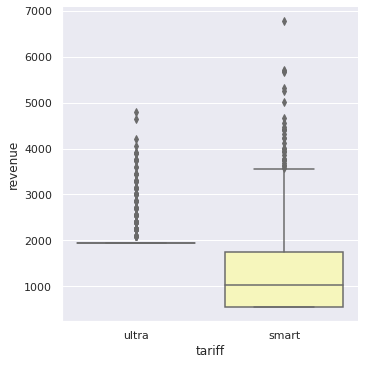

In [27]:
median_reven= sns.catplot(x='tariff', y='revenue', kind='box', data=grouped_data, orient='v', palette="Set3")

Медианные значения выручки по тарифам различаются почти в 2 раза. Мы видим, что у "медианного" пользователя тарифа "Смарт" с абонентской платой в 550 рублей, расход средств за месяц превышает плату по тарифу на 987-550= 437р(79,6%), значит, он вышел за рамки заложенных в тариф возможностей.   

По итогу вычислений можно сделать вывод, что наша альтернативная гипотеза подтвердилась:  доходы "Мегалайна", полученные от пользователя тарифа "Ультра" действительно отличаются в сравнении с доходом от пользователя с тарифом  "Смарт".

*Работаем со второй гипотезой:*

В качестве нулевой примем утверждение, что средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов.

В качестве альтернативной — средняя выручка пользователей из Москвы отличается от средней выручке пользователей из других регионов.

Статистическую значимость оставляем с тем же значением: α=1%

In [28]:
print('Формируем две переменные: с доходами, которые приносят жителями Москвы,  и с доходами от жителей регионов.')


moscow = grouped_data.query('city == "Москва"')['revenue']
regions = grouped_data.query('city != "Москва"')['revenue']

alpha = .01

results = st.ttest_ind(
    moscow, 
    regions, 
    equal_var=False)


print('Получаем:')
print('p-значение:', results.pvalue)
print('')
print('Формируем функцию, сравнивающую статитстическую значимость и полученное р-значение. Выводим результат на экран: ')
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

def det_region(city):
    if city == 'Москва': return 'Москва'
    else: return 'Другой регион'
    
grouped_data['region'] = grouped_data['city'].apply(det_region)
print('')
print('Формируем таблицу с медианными значениями выручки:')
print(grouped_data.pivot_table(index='region', values='revenue', aggfunc='median'))

Формируем две переменные: с доходами, которые приносят жителями Москвы,  и с доходами от жителей регионов.
Получаем:
p-значение: 0.5257376663729298

Формируем функцию, сравнивающую статитстическую значимость и полученное р-значение. Выводим результат на экран: 
Не получилось отвергнуть нулевую гипотезу

Формируем таблицу с медианными значениями выручки:
               revenue
region                
Другой регион   1583.0
Москва          1750.0


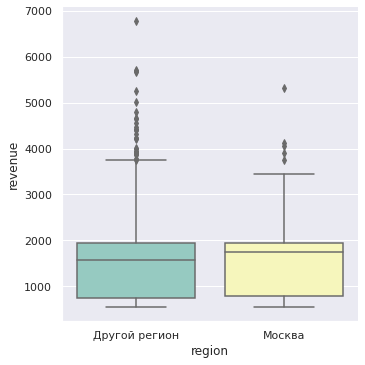

In [29]:
_ = sns.catplot(x="region", y='revenue', kind="box", data=grouped_data, orient='v', palette="Set3")

По гистограмме видно, что доходы от жителей Москвы практически не отличаются от дохода, полученного от жителей регионов. По статистическому исследованию нулевую гипотезу тоже нельзя опровергнуть. С учетом р-значения, вероятность ошибки при утверждении, что доходы москвичей и жителей регионов отличаются, равна 52.3% .


**Вывод:**

По результатам статистического анализа доходы от тарифа «Ультра» больше, чем от тарифа «Смарт»: в среднем «Мегалайн» от одного пользователя в месяц получает 1950 рублей и 988 рублей соответственно  (p−значение=o(1) ,  α=1%) .

*Особенности использования тарифов заключаются в следующем:*

Пользователям тарифа «Смарт» не хватает услуг в рамках тарифного пакета: кроме абонентской платы пользователи в среднем доплачивают еще 438 рублей ежемесячно (+79,6%).
Пользователи тарифа «Ультра», напротив, не используют тарифный пакет в полном объеме.
Средние доходы от пользователей в Москве не отличаются от доходов в других населенных пунктах: разница статистически незначима (p-значение: 0,523) и составляет 188 руб.: 1734 руб. в Москве против 1546 руб в других населенных пунктах.

**7. Общий вывод.**

В процессе исследования я сделала предварительный анализ тарифов на небольшой выборке клиентов в 500 человек с целью установить наиболее прибыльный для компании. Изначально были видвинуты для работы следующие гипотезы:
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.


В начале была произведена подготовка предоставленных таблиц к дальнейшей работе. Были заполнены пропуски логически обоснованными значениями, подтверждено отсутствие дубликатов, были изменены типы данных в столбцах с датами, а так же числовые значения были переведены в целочисленные на основании условий тарифов. Дана предварительная оценка использованию пользователями звонков и интернет-трафика. Далее были проведены необходимые для статистического анализа расчеты, результаты которых были добавлены в таблицу. Были оценены выбросы - по итогу они незначительны и являются частью характиристики "поведения" пользователей.  В процессе были использованы возможности визуализации.  Был проведен статистический анализ полученных данных с вычислением р-значения и определением величины статистической значимости, а так же с формулированием нулевой и альтернативной гипотез.  Были сформированы иллюстрирующие полученные зависимости диаграммы и графики. Поэтапно были сделаны выводы. 



На основании проделанных вычислений можно сформулировать следующие выводы в отношении первоначальных гепотез:
-  доходы от тарифа «Ультра» больше, чем от тарифа «Смарт»: медиванное значение дохода, получаемого «Мегалайном» от одного пользователя в месяц выходит 1950 рублей и 988 рублей соответственно.  

- доходы от жителей Москвы статистически незначительно  отличаются от дохода, полученного от жителей регионов. С учетом р-значения, вероятность ошибки при утверждении, что доходы москвичей и жителей регионов отличаются, составляет 50.3% . Следовательно, о значимом различии выручки с уверенностью сказать нельзя, необходимо расширение задач исследования и выборки в обеих группах.

Так же, можно отметить следующие особенности использования тарифов пользователями:

- пользователям тарифа «Смарт» не хватает объема услуг в рамках тарифного пакета: кроме абонентской платы пользователи в среднем доплачивают еще 438 рублей ежемесячно (+79,6%).
- пользователи тарифа «Ультра», напротив, не используют тарифный пакет в полном объеме, либо используют в большей степени одну из функций.

Исходя из полученных данных, можно дать следующие рекомендации компании:
- возможно, следует разработать более гибкий тариф для пользователей, которые готовы платить больше "смарта" ради большего объема определенных функций, но не готовы оплачивать "ультра" из-за ненужного объема побочных возможностей. 
- т к доходы, получаемые от жителей Москвы и жителей регионов статистически значимо не отличаются, есть резон уделить больше внимания развитию "рынка" вне мегаполиса и вместе с тем лучше изучить потребности жителей Москвы(и других городов-миллионников, тк они включены в "периферию", но дохода, больше, чем в Москве, мы не наблюдаем)




